# Mind-the-Gap Index

Notebook to test the Mind-The-Gap Index using currently available data.

## Import libraries

In [96]:
import os
import sys

import pandas as pd
import geopandas as gpd
import numpy as np

import math

import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

module_path = os.path.abspath(os.path.join('../../'))
if module_path not in sys.path:
    sys.path.append(module_path)
    import aup

## Download data

### Municipality boundaries

In [2]:
mun_schema = 'metropolis'
mun_folder = 'metro_list'

city = 'Guadalajara'

query = f"SELECT * FROM {mun_schema}.{mun_folder} WHERE \"city\" LIKE \'{city}\'"
mun_gdf = aup.gdf_from_query(query, geometry_col='geometry')

print(mun_gdf.shape)
mun_gdf.head(2)

(10, 6)


,CVEGEO,CVE_ENT,CVE_MUN,NOMGEO,geometry,city
0,14002,14,002,Acatlán de Juárez,"POLYGON ((-103.65448 20.50346, -103.65200 20.5...",Guadalajara
1,14039,14,039,Guadalajara,"POLYGON ((-103.31164 20.75098, -103.31014 20.7...",Guadalajara


## AGEB population by hexagon

In [3]:
cvegeo_list = list(mun_gdf.loc[mun_gdf.city==city]["CVEGEO"].unique())

In [4]:
# donwload hexagons with pop data
hex_pop = gpd.GeoDataFrame()
hex_folder = 'hex_bins_pop_2020'
hex_schema = 'censo'


# Iterates over municipality codes for each metropolitan area or capital
for cvegeo in cvegeo_list:
    # Downloads municipality polygon according to code
    query = f"SELECT * FROM {hex_schema}.{hex_folder} WHERE \"CVEGEO\" LIKE \'{cvegeo}%%\'"
    hex_tmp = aup.gdf_from_query(query, geometry_col='geometry')
    hex_pop = pd.concat([hex_pop, hex_tmp],
    ignore_index = True, axis = 0)
print(hex_pop.shape)
hex_pop.head(2)

(1187, 225)


,geometry,hex_id_8,CVEGEO,pobtot,pobfem,pobmas,p_0a2,p_0a2_f,p_0a2_m,p_3ymas,...,vph_telef,vph_cel,vph_inter,vph_stvp,vph_spmvpi,vph_cvj,vph_sinrtv,vph_sintlc,vph_sincint,vph_sintic
0,"POLYGON ((-103.61319 20.42802, -103.61772 20.4...",8849abc9ebfffff,14002,273.168550,135.64044,137.528090,13.123595,6.831461,6.292135,260.044950,...,13.662921,66.06741,34.426968,56.808990,9.168539,7.011236,2.067416,4.134831,33.348316,0.539326
1,"POLYGON ((-103.61374 20.43321, -103.61319 20.4...",8849abc9e3fffff,14002,98.333336,46.00000,43.333332,4.666666,2.333333,2.333333,84.666664,...,3.000000,22.00000,11.000000,18.666666,3.000000,2.000000,0.000000,0.000000,9.333333,0.000000


## 15 min cities

In [5]:
# donwload hexagons with time data
hex_time = gpd.GeoDataFrame()
hex_folder = 'time_15_min_analysis_hexres8'
hex_schema = 'prox_analysis'


# Download time data for city
query = f"SELECT * FROM {hex_schema}.{hex_folder} WHERE \"city\" LIKE \'{city}\'"
hex_time = aup.gdf_from_query(query, geometry_col='geometry')

print(hex_time.shape)
hex_time.head(2)

(1187, 30)


,hex_id_8,geometry,max_escuelas,max_preescolar,max_primaria,max_secundaria,max_servicios comunitarios,max_salud,max_guarderías,max_asistencia social,...,max_idx_15_min,pobtot,pobfem,pobmas,pob_0a14,pob_15a24,pob_25a59,p_60ymas,dens_pobha,city
0,8849abc9ebfffff,"POLYGON ((-103.61319 20.42802, -103.61772 20.4...",24.705283,24.705283,23.051588,20.315681,51.182696,40.473661,51.182696,22.870778,...,358.203036,273.168550,135.64044,137.528090,75.146068,48.988765,117.932583,31.101124,3.153691,Guadalajara
1,8849abc9e3fffff,"POLYGON ((-103.61374 20.43321, -103.61319 20.4...",40.805866,40.686460,40.805866,35.954972,49.267035,47.308015,49.267035,40.606266,...,349.975770,98.333336,46.00000,43.333332,26.666666,19.333333,40.666668,2.666667,1.135241,Guadalajara


## Data Treatment

In [6]:
hex_pop_ind = hex_pop[['hex_id_8','pobtot','p_12ymas','graproes','pder_ss','pea',
                      'vivtot','tvivparhab','ocupvivpar','prom_ocup','pro_ocup_c',
                      'vph_pisodt','vph_c_elec','vph_aguafv','vph_aeasp','vph_drenaj','vph_excsa',
                      'vph_inter','geometry']].copy()
print(hex_pop_ind.shape)
hex_pop_ind.head(4)

(1187, 19)


,hex_id_8,pobtot,p_12ymas,graproes,pder_ss,pea,vivtot,tvivparhab,ocupvivpar,prom_ocup,pro_ocup_c,vph_pisodt,vph_c_elec,vph_aguafv,vph_aeasp,vph_drenaj,vph_excsa,vph_inter,geometry
0,8849abc9ebfffff,273.168550,212.40450,8.860000,218.78651,131.056180,83.325840,72.179780,273.168550,3.780000,1.060000,71.730340,71.820220,1.168539,70.292140,70.741570,70.561800,34.426968,"POLYGON ((-103.61319 20.42802, -103.61772 20.4..."
1,8849abc9e3fffff,98.333336,68.00000,8.430644,68.00000,42.333332,29.666666,22.666666,89.333336,3.579390,1.026576,22.666666,22.666666,0.000000,22.333334,22.666666,22.666666,11.000000,"POLYGON ((-103.61374 20.43321, -103.61319 20.4..."
2,8849abc999fffff,60.000000,48.00000,8.645000,47.00000,27.000000,31.999998,14.000000,60.000000,4.284500,1.279000,14.000000,14.000000,0.000000,13.000000,11.000000,14.000000,9.000001,"POLYGON ((-103.64928 20.44809, -103.65381 20.4..."
3,8849abc9e7fffff,1247.971700,984.30505,9.245727,971.08480,577.124270,406.333300,337.282470,1247.971700,3.700087,0.958633,334.858730,336.180760,2.423729,330.666700,336.401100,336.180760,172.271200,"POLYGON ((-103.59961 20.43722, -103.60414 20.4..."


In [7]:
hex_time_ind = hex_time[['hex_id_8','max_preescolar','max_primaria',
                         'max_secundaria','max_salud']].copy()
print(hex_time_ind.shape)
hex_time_ind.head(4)

(1187, 5)


,hex_id_8,max_preescolar,max_primaria,max_secundaria,max_salud
0,8849abc9ebfffff,24.705283,23.051588,20.315681,40.473661
1,8849abc9e3fffff,40.686460,40.805866,35.954972,47.308015
2,8849abc999fffff,18.294332,25.496011,100.417806,31.854511
3,8849abc9e7fffff,18.711042,13.808051,18.252167,30.565707


In [8]:
hex_ind = hex_pop_ind.merge(hex_time_ind, on='hex_id_8')
hex_ind.head(2)

,hex_id_8,pobtot,p_12ymas,graproes,pder_ss,pea,vivtot,tvivparhab,ocupvivpar,prom_ocup,...,vph_aguafv,vph_aeasp,vph_drenaj,vph_excsa,vph_inter,geometry,max_preescolar,max_primaria,max_secundaria,max_salud
0,8849abc9ebfffff,273.168550,212.4045,8.860000,218.78651,131.056180,83.325840,72.179780,273.168550,3.78000,...,1.168539,70.292140,70.741570,70.561800,34.426968,"POLYGON ((-103.61319 20.42802, -103.61772 20.4...",24.705283,23.051588,20.315681,40.473661
1,8849abc9e3fffff,98.333336,68.0000,8.430644,68.00000,42.333332,29.666666,22.666666,89.333336,3.57939,...,0.000000,22.333334,22.666666,22.666666,11.000000,"POLYGON ((-103.61374 20.43321, -103.61319 20.4...",40.686460,40.805866,35.954972,47.308015


## Data analysis

### Personas por cuarto

<AxesSubplot:>

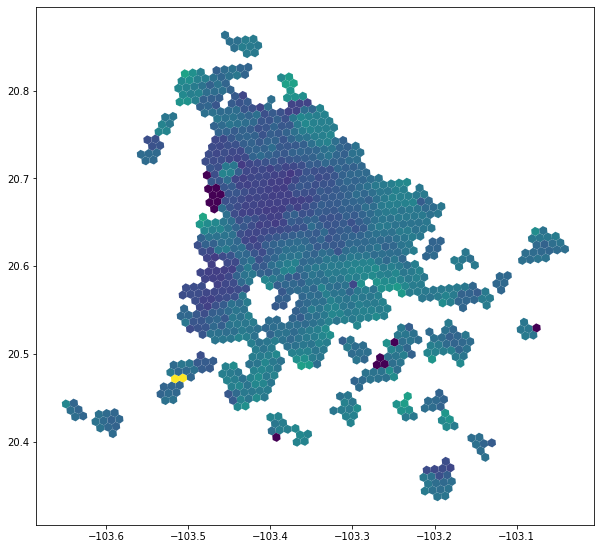

In [9]:
fig,ax = plt.subplots(figsize=(10,10))

hex_ind.plot('pro_ocup_c', ax=ax)

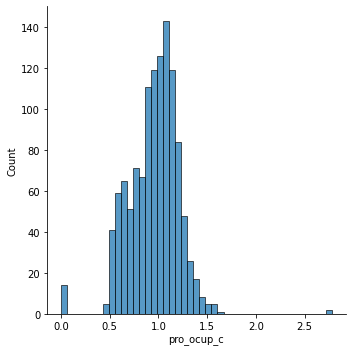

In [10]:
sns.displot(hex_ind['pro_ocup_c'])

### Grado escolaridad

<AxesSubplot:>

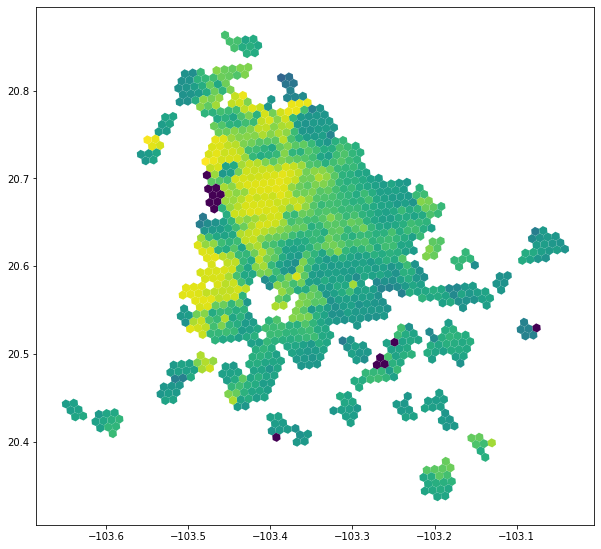

In [11]:
fig,ax = plt.subplots(figsize=(10,10))

hex_ind.plot('graproes', ax=ax)

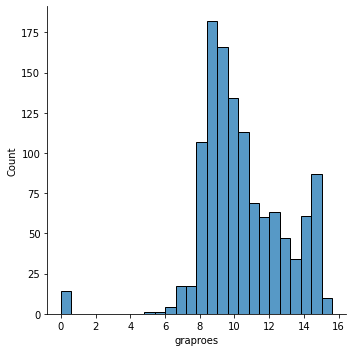

In [12]:
sns.displot(hex_ind['graproes'])

### Tasa de empleo

<AxesSubplot:>

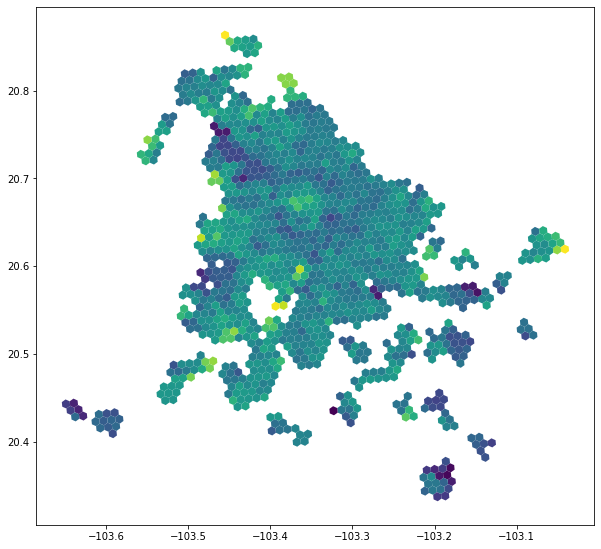

In [13]:
hex_ind['tasa_empleo'] = hex_ind['pea'] / hex_ind['p_12ymas']

fig,ax = plt.subplots(figsize=(10,10))

hex_ind.plot('tasa_empleo', ax=ax)

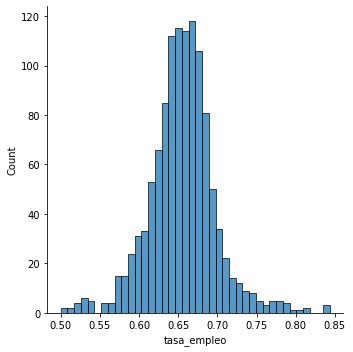

In [14]:
sns.displot(hex_ind['tasa_empleo'])

### Internet

<AxesSubplot:>

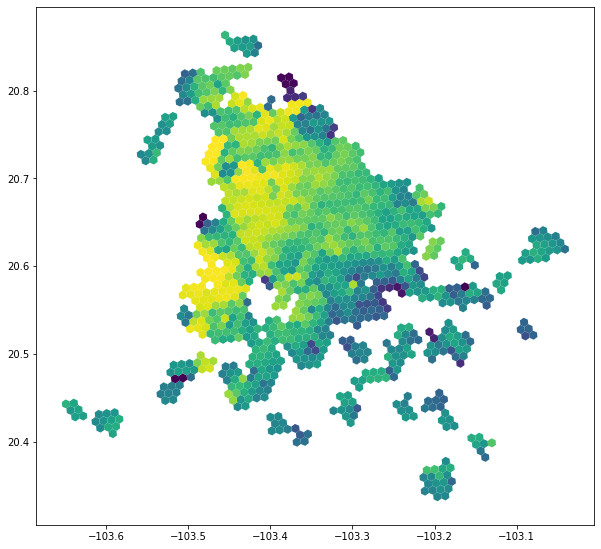

In [15]:
hex_ind['pct_internet'] = hex_ind['vph_inter'] / hex_ind['tvivparhab']

fig,ax = plt.subplots(figsize=(10,10))

hex_ind.plot('pct_internet', ax=ax)

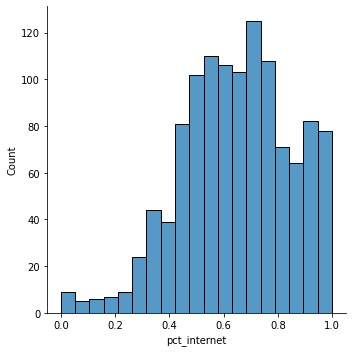

In [16]:
sns.displot(hex_ind['pct_internet'])

### Access to health services

<AxesSubplot:>

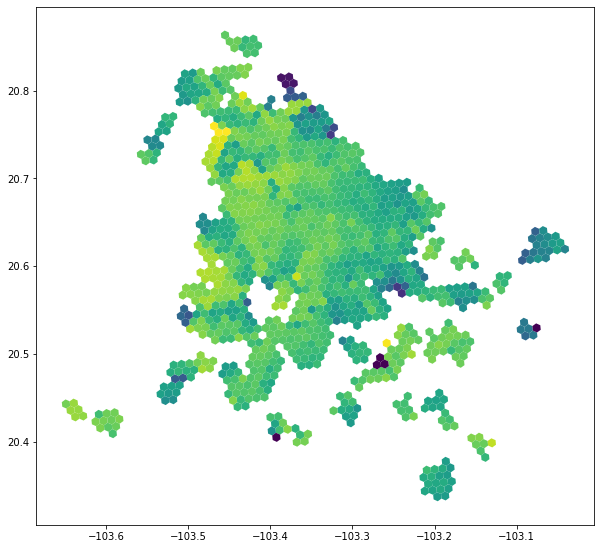

In [17]:
hex_ind['pct_per_der_ss'] = hex_ind['pder_ss'] / hex_ind['pobtot']

fig,ax = plt.subplots(figsize=(10,10))

hex_ind.plot('pct_per_der_ss', ax=ax)

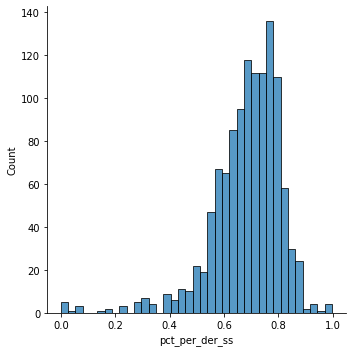

In [18]:
sns.displot(hex_ind['pct_per_der_ss'])

### Informal employment

<AxesSubplot:>

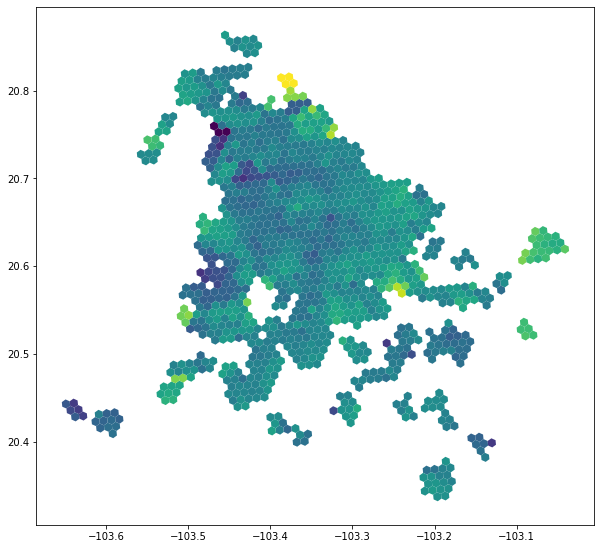

In [19]:
hex_ind['pct_p12ymas'] = hex_ind['p_12ymas'] / hex_ind['pobtot']
hex_ind['p_der_ss_12ymas'] = hex_ind['pder_ss'] * hex_ind['pct_p12ymas']
hex_ind['empleo_informal'] = hex_ind['pea'] - hex_ind['p_der_ss_12ymas']
hex_ind['tasa_empleo_informal'] = hex_ind['empleo_informal'] / hex_ind['pea']

fig,ax = plt.subplots(figsize=(10,10))

hex_ind.plot('tasa_empleo_informal', ax=ax)

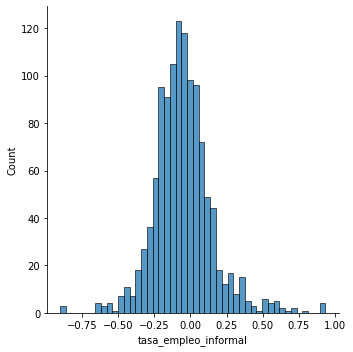

In [20]:
sns.displot(hex_ind['tasa_empleo_informal'])

En su estado actual, no podemos utilizar el método para estmiar el porcentaje de empleo informal.

### Access to electricity

<AxesSubplot:>

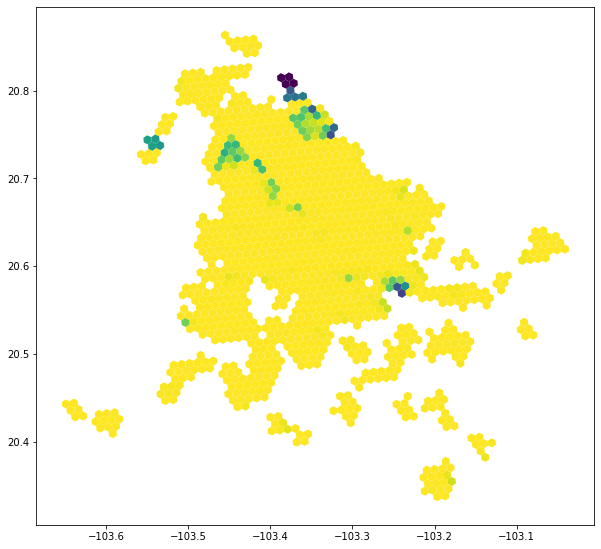

In [21]:
hex_ind['pct_electricidad'] = hex_ind['vph_c_elec'] / hex_ind['tvivparhab']

fig,ax = plt.subplots(figsize=(10,10))

hex_ind.plot('pct_electricidad', ax=ax)

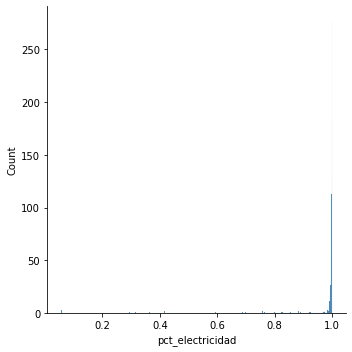

In [22]:
sns.displot(hex_ind['pct_electricidad'])

### Access to clean water

<AxesSubplot:>

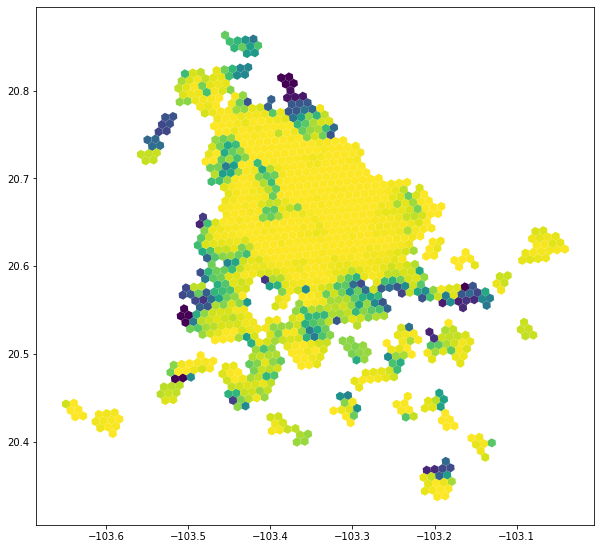

In [23]:
hex_ind['pct_agua'] = hex_ind['vph_aeasp']  / hex_ind['tvivparhab']

fig,ax = plt.subplots(figsize=(10,10))

hex_ind.plot('pct_agua', ax=ax)

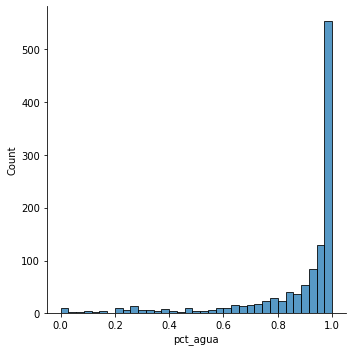

In [24]:
sns.displot(hex_ind['pct_agua'])

### Access to drainage

<AxesSubplot:>

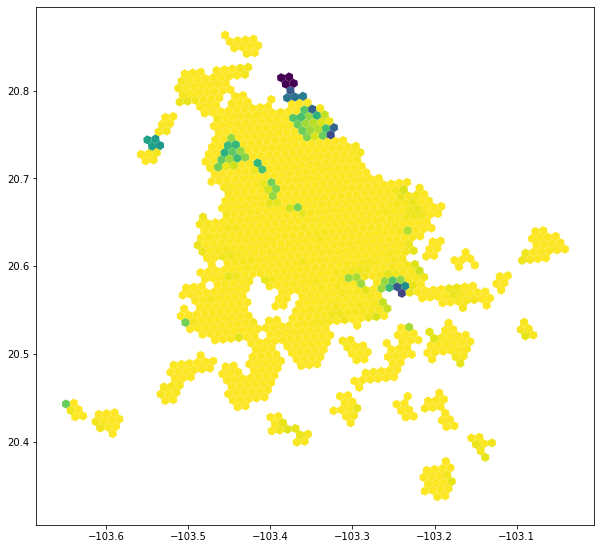

In [25]:
hex_ind['pct_drenaje'] = hex_ind['vph_drenaj']  / hex_ind['tvivparhab']

fig,ax = plt.subplots(figsize=(10,10))

hex_ind.plot('pct_drenaje', ax=ax)

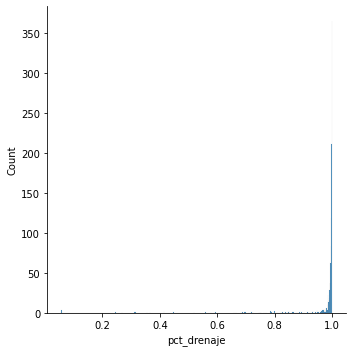

In [26]:
sns.displot(hex_ind['pct_drenaje'])

### Piso de tierra

<AxesSubplot:>

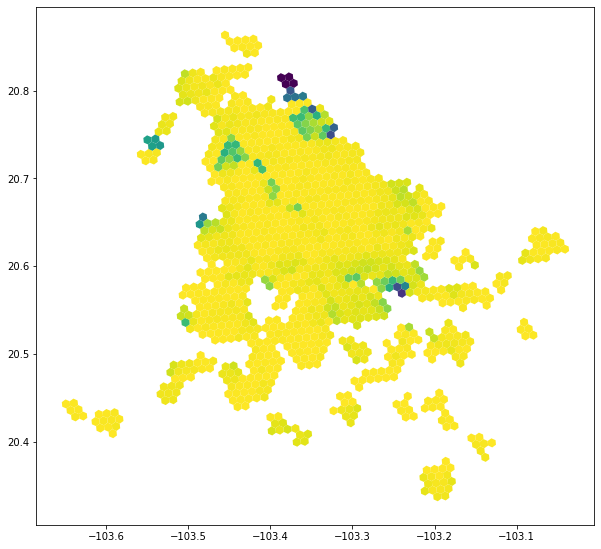

In [27]:
hex_ind['pct_piso_tierra'] = hex_ind['vph_pisodt']  / hex_ind['tvivparhab']

fig,ax = plt.subplots(figsize=(10,10))

hex_ind.plot('pct_piso_tierra', ax=ax)

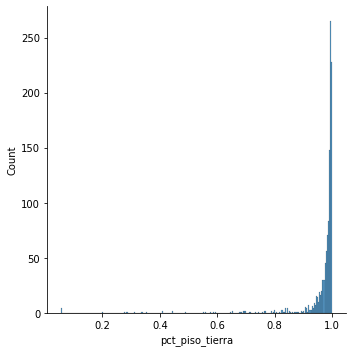

In [28]:
sns.displot(hex_ind['pct_piso_tierra'])

#### Access to toilet

<AxesSubplot:>

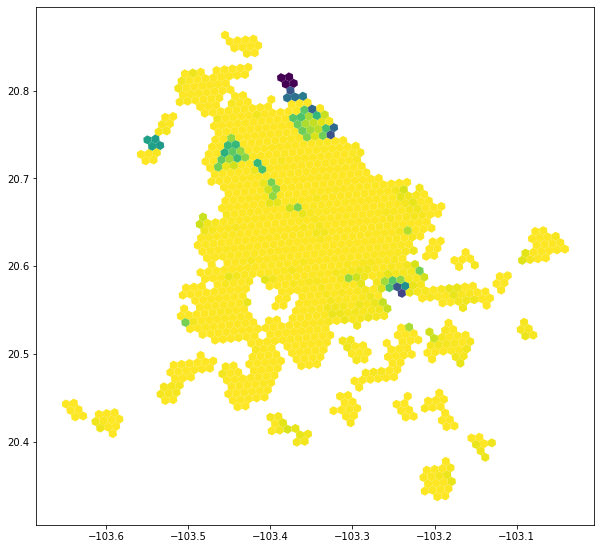

In [29]:
hex_ind['pct_excusado'] = hex_ind['vph_excsa']  / hex_ind['tvivparhab']

fig,ax = plt.subplots(figsize=(10,10))

hex_ind.plot('pct_excusado', ax=ax)

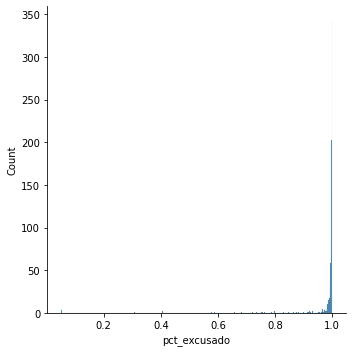

In [30]:
sns.displot(hex_ind['pct_excusado'])

## Variable preparation

In [31]:
from sklearn.preprocessing import MinMaxScaler

### Employment rate

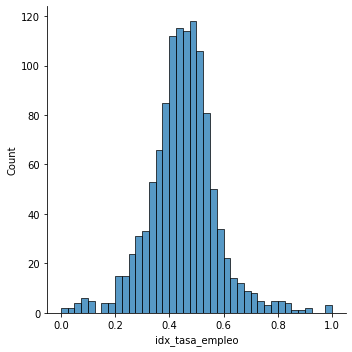

In [32]:
scaler = MinMaxScaler()
ind = np.reshape(hex_ind['tasa_empleo'].to_numpy(), (-1,1))
scaler = MinMaxScaler()
scaler.fit(ind)

hex_ind['idx_tasa_empleo'] = scaler.transform(ind)

sns.displot(hex_ind['idx_tasa_empleo'])

### Personas por cuarto

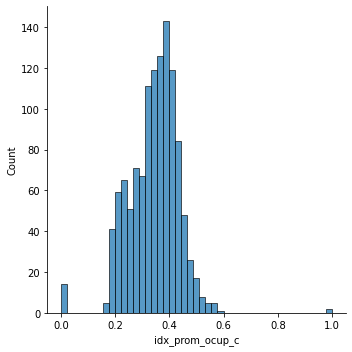

In [33]:
scaler = MinMaxScaler()
ind = np.reshape(hex_ind['pro_ocup_c'].to_numpy(), (-1,1))
scaler = MinMaxScaler()
scaler.fit(ind)

hex_ind['idx_prom_ocup_c'] = scaler.transform(ind)

sns.displot(hex_ind['idx_prom_ocup_c'])

### Adult education level

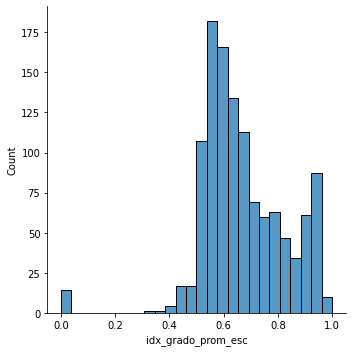

In [34]:
scaler = MinMaxScaler()
ind = np.reshape(hex_ind['graproes'].to_numpy(), (-1,1))
scaler = MinMaxScaler()
scaler.fit(ind)

hex_ind['idx_grado_prom_esc'] = scaler.transform(ind)

sns.displot(hex_ind['idx_grado_prom_esc'])

### Primary education

#### Preeschool

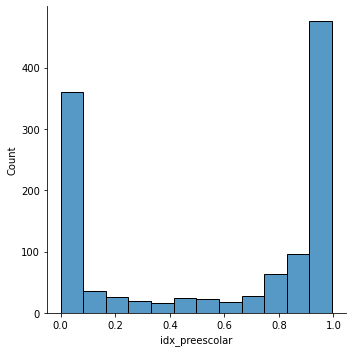

In [35]:
k = aup.sigmoidal_function_constant(10, 15)

hex_ind['idx_preescolar'] = hex_ind['max_preescolar'].apply(lambda di: aup.sigmoidal_function(k, di=di, d0=15))

sns.displot(hex_ind['idx_preescolar'])

#### Elementary

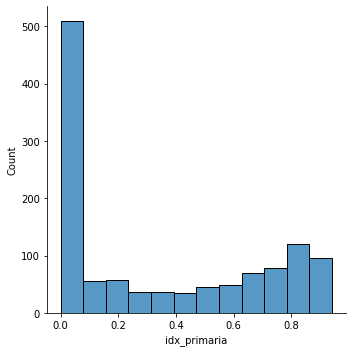

In [36]:
mid_point_limit = 10

k = aup.sigmoidal_function_constant(5, mid_point_limit)

hex_ind['idx_primaria'] = hex_ind['max_primaria'].apply(lambda di: aup.sigmoidal_function(k, di=di, d0=mid_point_limit))

sns.displot(hex_ind['idx_primaria'])

#### High-school

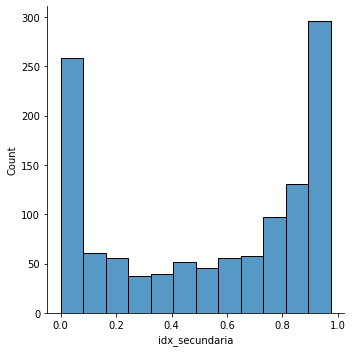

In [37]:
mid_point_limit = 30

k = aup.sigmoidal_function_constant(15, mid_point_limit)

hex_ind['idx_secundaria'] = hex_ind['max_secundaria'].apply(lambda di: aup.sigmoidal_function(k, di=di, d0=mid_point_limit))

sns.displot(hex_ind['idx_secundaria'])

#### Combined index

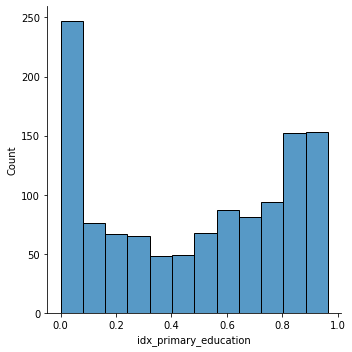

In [38]:
hex_ind['idx_primary_education'] = 0.333*hex_ind['idx_secundaria'] + 0.334*hex_ind['idx_primaria'] + 0.333*hex_ind['idx_preescolar']

sns.displot(hex_ind['idx_primary_education'])

### Primary health contact

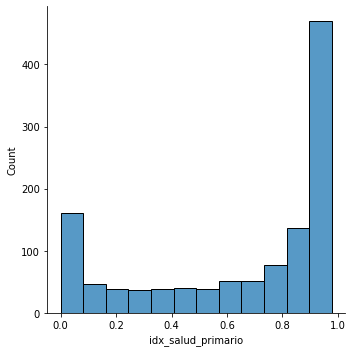

In [39]:
mid_point_limit = 30

k = aup.sigmoidal_function_constant(15, mid_point_limit)

hex_ind['idx_salud_primario'] = hex_ind['max_salud'].apply(lambda di: aup.sigmoidal_function(k, di=di, d0=mid_point_limit))

sns.displot(hex_ind['idx_salud_primario'])

## Index calculation

In [40]:
hex_ind['segregation_idx'] = (hex_ind['idx_salud_primario'] + hex_ind['idx_primary_education'] + hex_ind['idx_tasa_empleo'] + 
                            hex_ind['idx_grado_prom_esc'] + hex_ind['pct_internet'] +  hex_ind['pct_drenaje'] + 
                              hex_ind['pct_agua'] + hex_ind['pct_electricidad'] + hex_ind['pct_excusado'] +
                              hex_ind['pct_per_der_ss'] + hex_ind['idx_prom_ocup_c'] + hex_ind['pct_piso_tierra'])

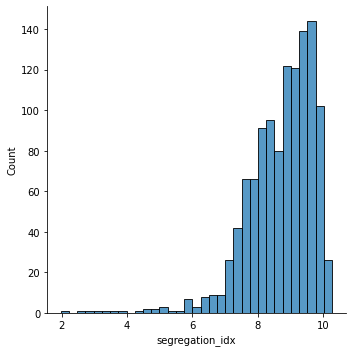

In [41]:
sns.displot(hex_ind['segregation_idx'])

### Data transformation

In [148]:
from sklearn.preprocessing import PowerTransformer, QuantileTransformer

pt = PowerTransformer()
qt = QuantileTransformer(n_quantiles=500, output_distribution='normal')

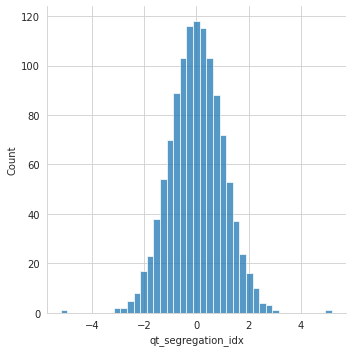

In [151]:
array = np.array(hex_ind['segregation_idx']).reshape(-1, 1)

x = qt.fit_transform(array)

hex_ind['qt_segregation_idx'] = x

sns.displot(hex_ind['qt_segregation_idx'])

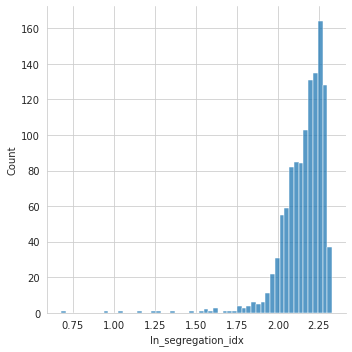

In [100]:
hex_ind['ln_segregation_idx'] = hex_ind['segregation_idx'].apply(lambda x: math.log(x))

sns.displot(hex_ind['ln_segregation_idx'])

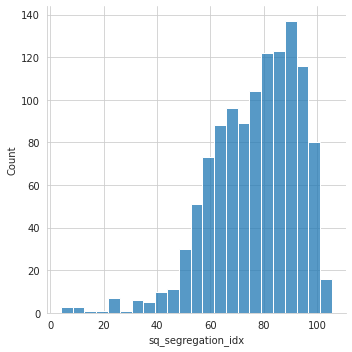

In [101]:
hex_ind['sq_segregation_idx'] = hex_ind['segregation_idx'] * hex_ind['segregation_idx'] 

sns.displot(hex_ind['sq_segregation_idx'])

#### Remove null values

In [152]:
idx = hex_ind['qt_segregation_idx'].isna()
hex_ind = hex_ind.loc[~idx].copy()

<AxesSubplot:>

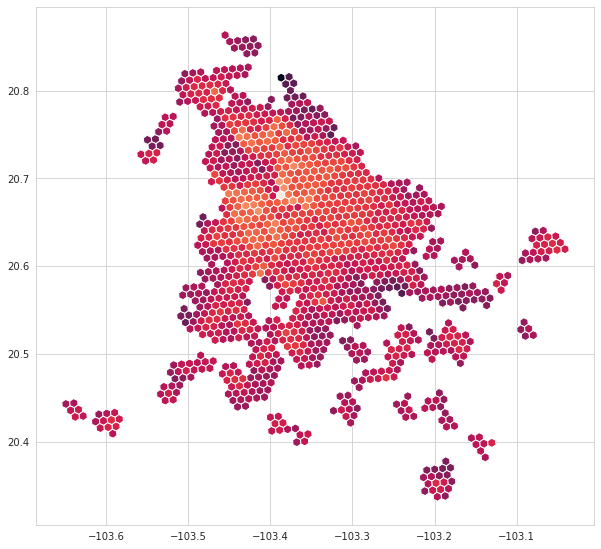

In [153]:
fig,ax = plt.subplots(figsize=(10,10))

hex_ind.plot('qt_segregation_idx', ax=ax)

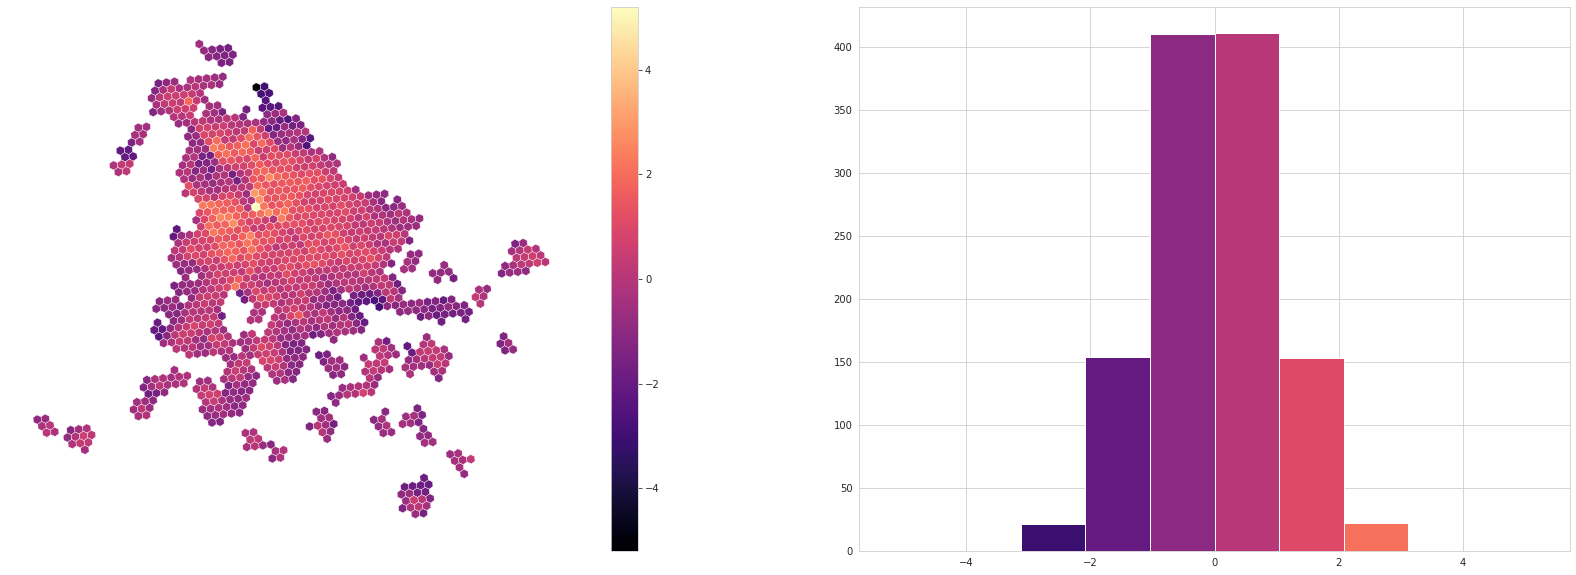

In [154]:
column_analysis = 'qt_segregation_idx'

sns.set_style("whitegrid")

fig, ax = plt.subplots(1,2, figsize=(28,10))
hex_ind.plot(column=column_analysis, linewidth=0.4,
                       legend=True, ax=ax[0], cmap = 'magma') 
ax[0].set_axis_off()

hex_ind.sort_values(column_analysis,inplace=True)
hex_ind.reset_index(drop=True, inplace=True)
n, bins, patches = ax[1].hist(hex_ind[column_analysis],
                             10, color='green')

cm = plt.cm.magma
 
# n, bins, patches = plt.hist(data, 25, normed=1, color='green')
for i, p in enumerate(patches):
    plt.setp(p, 'facecolor', cm(i/len(n))) # notice the i/25

In [45]:
import esda
import pysal

<AxesSubplot:>

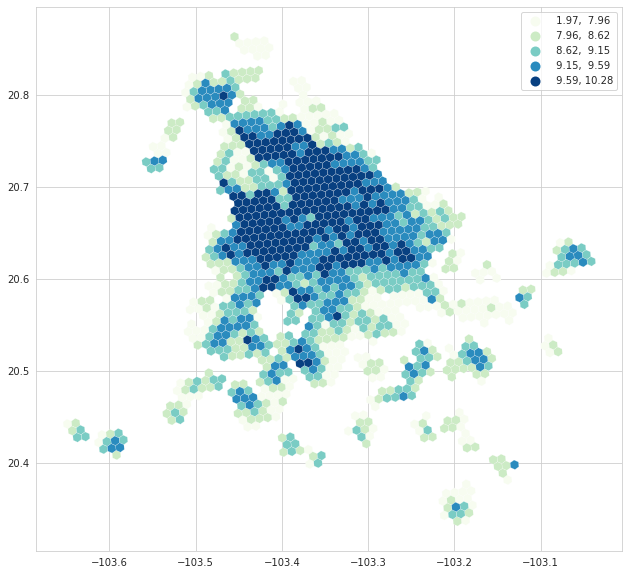

In [46]:
fig, ax = plt.subplots(figsize=(12,10), subplot_kw={'aspect':'equal'})
hex_ind.plot(column=column_analysis, 
              linewidth=0.2, scheme='Quantiles', 
              k=5, cmap='GnBu', legend=True, ax=ax)

In [47]:
import libpysal as lps

df = hex_ind
wq =  lps.weights.Queen.from_dataframe(df)
wq.transform = 'r'

/home/vscode/anaconda3/envs/odc/lib/python3.10/site-packages/libpysal/weights/weights.py:172: UserWarning: The weights matrix is not fully connected: 
 There are 20 disconnected components.
  warnings.warn(message)


In [48]:
y = df[column_analysis]
ylag = lps.weights.lag_spatial(wq, y)

In [49]:
wq = lps.weights.distance.Kernel.from_dataframe(df[[column_analysis,'geometry']])

li = esda.moran.Moran_Local(y, wq)

/home/vscode/anaconda3/envs/odc/lib/python3.10/site-packages/libpysal/weights/weights.py:172: UserWarning: The weights matrix is not fully connected: 
 There are 10 disconnected components.
  warnings.warn(message)


In [50]:
li.q

array([3, 3, 3, ..., 1, 1, 1])

In [51]:
sig = 1 * (li.p_sim < 0.05)
hotspot = 1 * (sig * li.q==1)
coldspot = 3 * (sig * li.q==3)
doughnut = 2 * (sig * li.q==2)
diamond = 4 * (sig * li.q==4)
spots = hotspot + coldspot + doughnut + diamond

In [52]:
spot_labels = [ '0 ns', '1 hot spot', '2 doughnut', '3 cold spot', '4 diamond']
labels = [spot_labels[i] for i in spots]

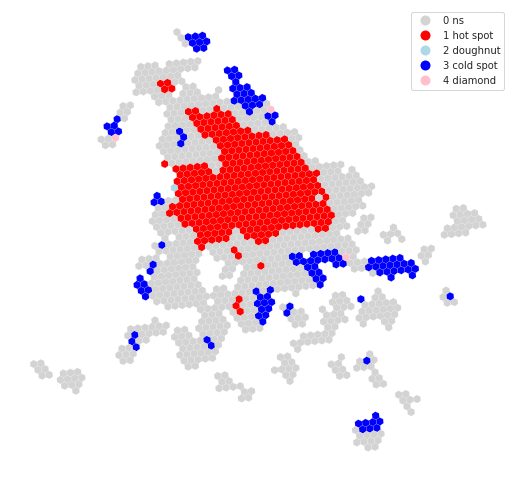

In [53]:
from matplotlib import colors
hmap = colors.ListedColormap([ 'lightgrey', 'red', 'lightblue', 'blue', 'pink'])
f, ax = plt.subplots(1, figsize=(9, 9))
df.assign(cl=labels).plot(column='cl', categorical=True, \
        k=2, cmap=hmap, linewidth=0.1, ax=ax, \
        edgecolor='white', legend=True)
ax.set_axis_off()
plt.show()

## Spatial data analysis

In [155]:
hex_esda = hex_ind.copy()

<AxesSubplot:>

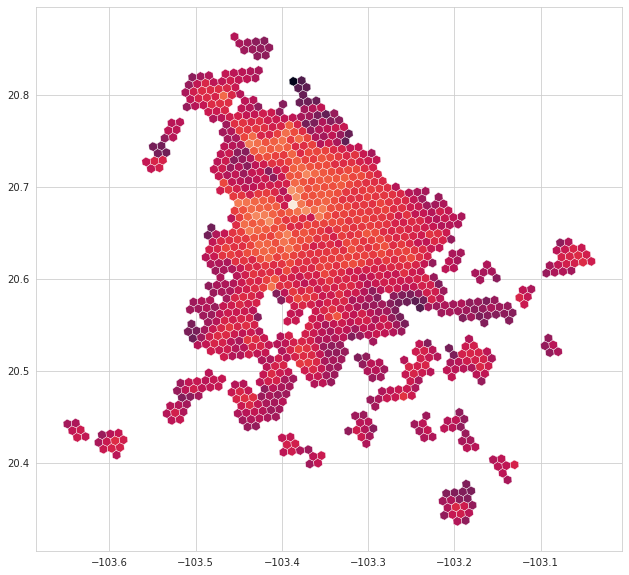

In [163]:
column_analysis = 'qt_segregation_idx'

fig, ax = plt.subplots(figsize=(12,10), subplot_kw={'aspect':'equal'})
hex_esda.plot(column=column_analysis, linewidth=0.4, ax=ax)

<AxesSubplot:>

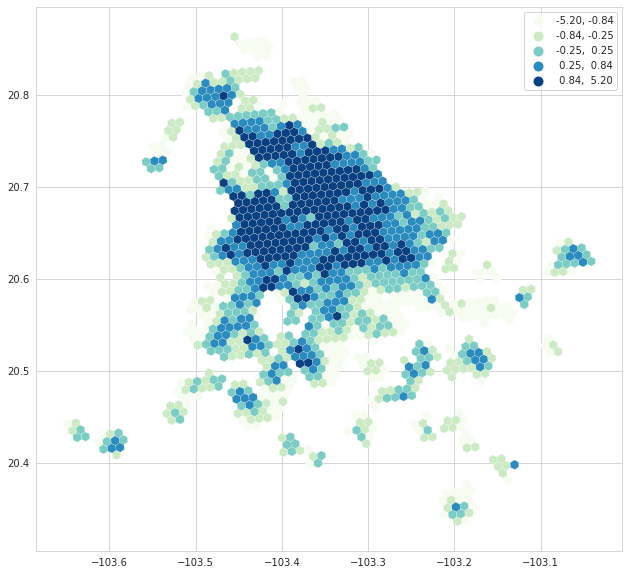

In [164]:
fig, ax = plt.subplots(figsize=(12,10), subplot_kw={'aspect':'equal'})
hex_esda.plot(column=column_analysis, 
              linewidth=0.2, scheme='Quantiles', 
              k=5, cmap='GnBu', legend=True, ax=ax)

### Spatial autocorrelation

In [165]:
import libpysal as lps

df = hex_esda
wq =  lps.weights.Queen.from_dataframe(df)
wq.transform = 'r'

/home/vscode/anaconda3/envs/odc/lib/python3.10/site-packages/libpysal/weights/weights.py:172: UserWarning: The weights matrix is not fully connected: 
 There are 20 disconnected components.
  warnings.warn(message)


In [166]:
y = df[column_analysis]
ylag = lps.weights.lag_spatial(wq, y)

In [167]:
ylag

array([-2.89951406, -3.5498536 , -1.95371888, ...,  2.33427312,
        1.10313208,  1.471644  ])

In [168]:
import mapclassify as mc
ylagq5 = mc.Quantiles(ylag, k=5)

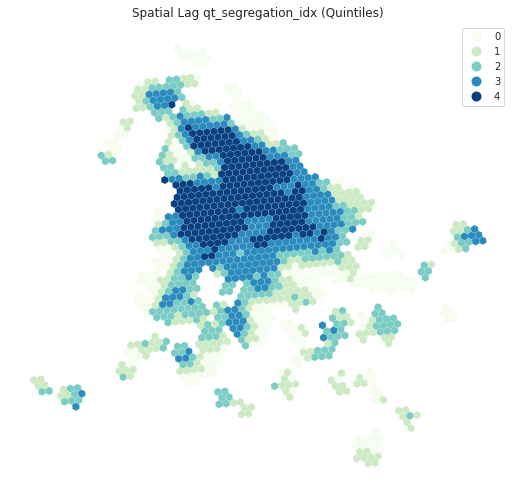

In [169]:
f, ax = plt.subplots(1, figsize=(9, 9))
df.assign(cl=ylagq5.yb).plot(column='cl', categorical=True, \
        k=5, cmap='GnBu', linewidth=0.1, ax=ax, \
        edgecolor='white', legend=True)
ax.set_axis_off()
plt.title(f"Spatial Lag {column_analysis} (Quintiles)")

plt.show()

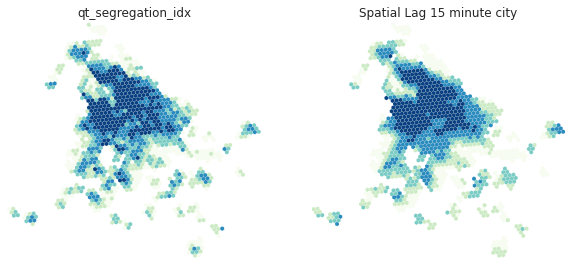

In [170]:
import numpy as np

df[f'lag_{column_analysis}'] = ylag
f,ax = plt.subplots(1,2,figsize=(10,8))
df.plot(column=column_analysis, ax=ax[0], linewidth=0.1,
        scheme="quantiles",  k=5, cmap='GnBu')
ax[0].axis(df.total_bounds[np.asarray([0,2,1,3])])
ax[0].set_title(column_analysis)
df.plot(column=f'lag_{column_analysis}', ax=ax[1], linewidth=0.1,
        scheme='quantiles', cmap='GnBu', k=5)
ax[1].axis(df.total_bounds[np.asarray([0,2,1,3])])
ax[1].set_title("Spatial Lag 15 minute city")
ax[0].axis('off')
ax[1].axis('off')
plt.show()

### Global spatial autocorrelation

In [171]:
y.median()

0.001797438180114346

In [172]:
y_above = y > y.median()
sum(y_above)

586

In [173]:
y_below = y < y.median()
sum(y_below)

586

In [174]:
labels = ["0 Low", "1 High"]
y_above = [labels[i] for i in 1*y_above] 
df['yb'] = y_above

<AxesSubplot:>

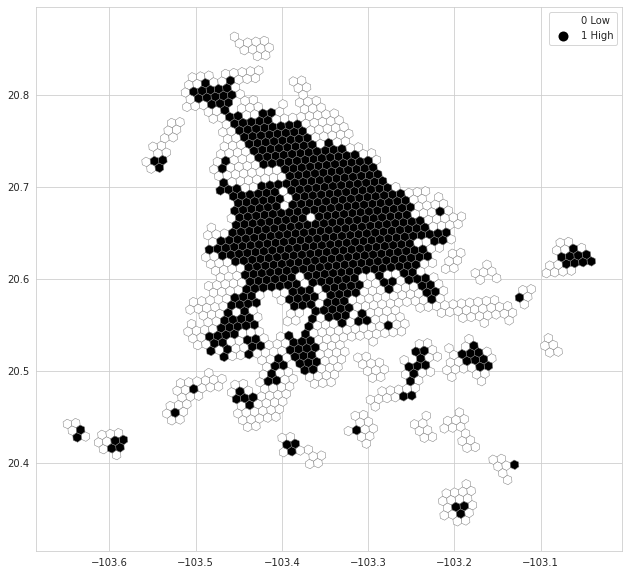

In [175]:
fig, ax = plt.subplots(figsize=(12,10), subplot_kw={'aspect':'equal'})
df.plot(column='yb', cmap='binary', linewidth=0.5, edgecolor='grey', legend=True, ax=ax)

In [176]:
yb = 1 * (y > y.median()) # convert back to binary
wq =  lps.weights.Queen.from_dataframe(df)
wq.transform = 'b'
np.random.seed(12345)
jc = esda.join_counts.Join_Counts(yb, wq)

/home/vscode/anaconda3/envs/odc/lib/python3.10/site-packages/libpysal/weights/weights.py:172: UserWarning: The weights matrix is not fully connected: 
 There are 20 disconnected components.
  warnings.warn(message)


In [177]:
jc.mean_bb

737.9469469469469

Text(0.5, 0, 'BB Counts')

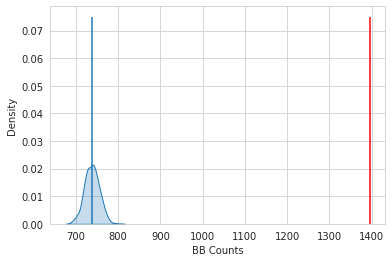

In [178]:
import seaborn as sbn
sbn.kdeplot(jc.sim_bb, shade=True)
plt.vlines(jc.bb, 0, 0.075, color='r')
plt.vlines(jc.mean_bb, 0,0.075)
plt.xlabel('BB Counts')

#### pseudo p-value

In [179]:
jc.p_sim_bb

0.001

### continuous case

In [180]:
wq.transform = 'r'

In [181]:
y = df[column_analysis]

#### Moran's I

In [182]:
np.random.seed(12345)
mi = esda.moran.Moran(y, wq)
mi.I

0.7563325096491966

Text(0.5, 0, "Moran's I")

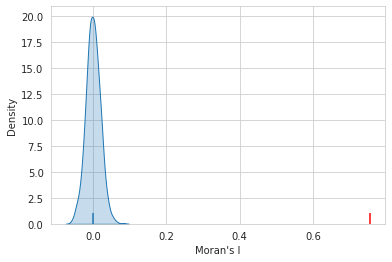

In [183]:
sbn.kdeplot(mi.sim, shade=True)
plt.vlines(mi.I, 0, 1, color='r')
plt.vlines(mi.EI, 0,1)
plt.xlabel("Moran's I")

In [184]:
mi.p_sim

0.001

### Local auto-correlation

In [185]:
np.random.seed(12345)

In [186]:
wq.transform = 'r'
lag_time = lps.weights.lag_spatial(wq, df[column_analysis])

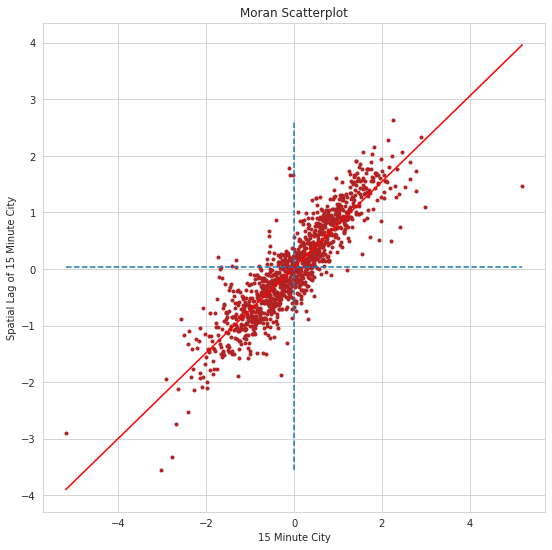

In [187]:
time = df[column_analysis]
b, a = np.polyfit(time, lag_time, 1)
f, ax = plt.subplots(1, figsize=(9, 9))

plt.plot(time, lag_time, '.', color='firebrick')

 # dashed vert at mean of the price
plt.vlines(time.mean(), lag_time.min(), lag_time.max(), linestyle='--')
 # dashed horizontal at mean of lagged price 
plt.hlines(lag_time.mean(), time.min(), time.max(), linestyle='--')

# red line of best fit using global I as slope
plt.plot(time, a + b*time, 'r')
plt.title('Moran Scatterplot')
plt.ylabel('Spatial Lag of 15 Minute City')
plt.xlabel('15 Minute City')
plt.show()

In [188]:
wq = lps.weights.distance.Kernel.from_dataframe(df[[column_analysis,'geometry']])

li = esda.moran.Moran_Local(y, wq)

/home/vscode/anaconda3/envs/odc/lib/python3.10/site-packages/libpysal/weights/weights.py:172: UserWarning: The weights matrix is not fully connected: 
 There are 10 disconnected components.
  warnings.warn(message)


In [189]:
li.q

array([3, 3, 3, ..., 1, 1, 1])

In [190]:
(li.p_sim < 0.05).sum()

479

In [191]:
sig = li.p_sim < 0.05
hotspot = sig * li.q==1
coldspot = sig * li.q==3
doughnut = sig * li.q==2
diamond = sig * li.q==4

In [192]:
spots = ['n.sig.', 'hot spot']
labels = [spots[i] for i in hotspot*1]

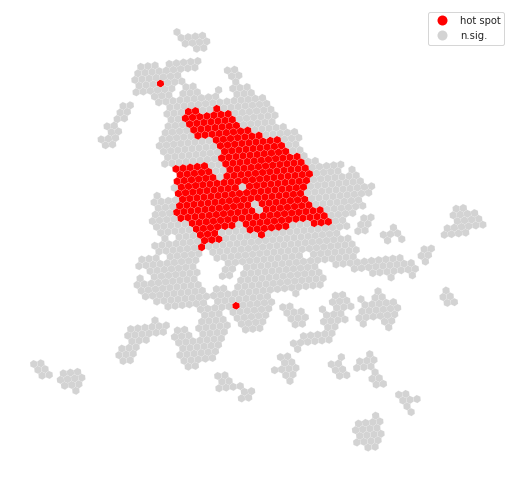

In [193]:
df = df
from matplotlib import colors
hmap = colors.ListedColormap(['red', 'lightgrey'])
f, ax = plt.subplots(1, figsize=(9, 9))
df.assign(cl=labels).plot(column='cl', categorical=True, \
        k=2, cmap=hmap, linewidth=0.1, ax=ax, \
        edgecolor='white', legend=True)
ax.set_axis_off()
plt.show()

In [194]:
spots = ['n.sig.', 'cold spot']
labels = [spots[i] for i in coldspot*1]

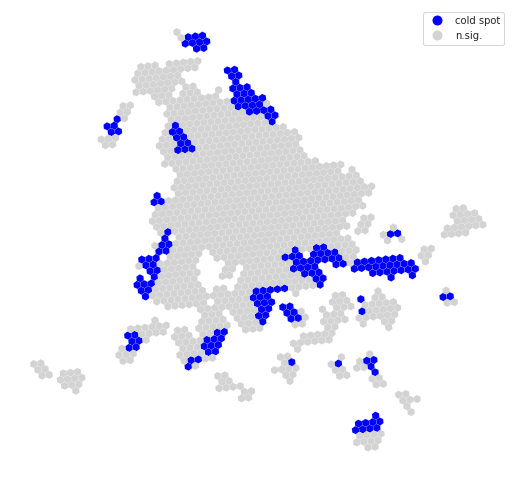

In [195]:
df = df
from matplotlib import colors
hmap = colors.ListedColormap(['blue', 'lightgrey'])
f, ax = plt.subplots(1, figsize=(9, 9))
df.assign(cl=labels).plot(column='cl', categorical=True, \
        k=2, cmap=hmap, linewidth=0.1, ax=ax, \
        edgecolor='white', legend=True)
ax.set_axis_off()
plt.show()

In [196]:
sig = 1 * (li.p_sim < 0.05)
hotspot = 1 * (sig * li.q==1)
coldspot = 3 * (sig * li.q==3)
doughnut = 2 * (sig * li.q==2)
diamond = 4 * (sig * li.q==4)
spots = hotspot + coldspot + doughnut + diamond
spots

array([3, 3, 3, ..., 1, 1, 1])

In [197]:
spot_labels = [ '0 ns', '1 hot spot', '2 doughnut', '3 cold spot', '4 diamond']
labels = [spot_labels[i] for i in spots]

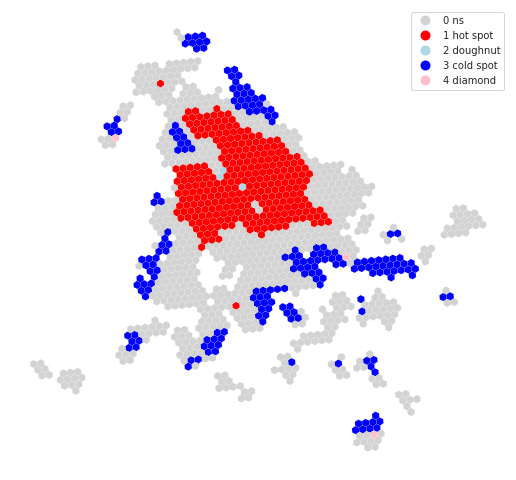

In [198]:
from matplotlib import colors
hmap = colors.ListedColormap([ 'lightgrey', 'red', 'lightblue', 'blue', 'pink'])
f, ax = plt.subplots(1, figsize=(9, 9))
df.assign(cl=labels).plot(column='cl', categorical=True, \
        k=2, cmap=hmap, linewidth=0.1, ax=ax, \
        edgecolor='white', legend=True)
ax.set_axis_off()
plt.show()

In [199]:
from splot import esda as esdaplot

In [200]:
lisa = esda.moran.Moran_Local(df[column_analysis], wq)

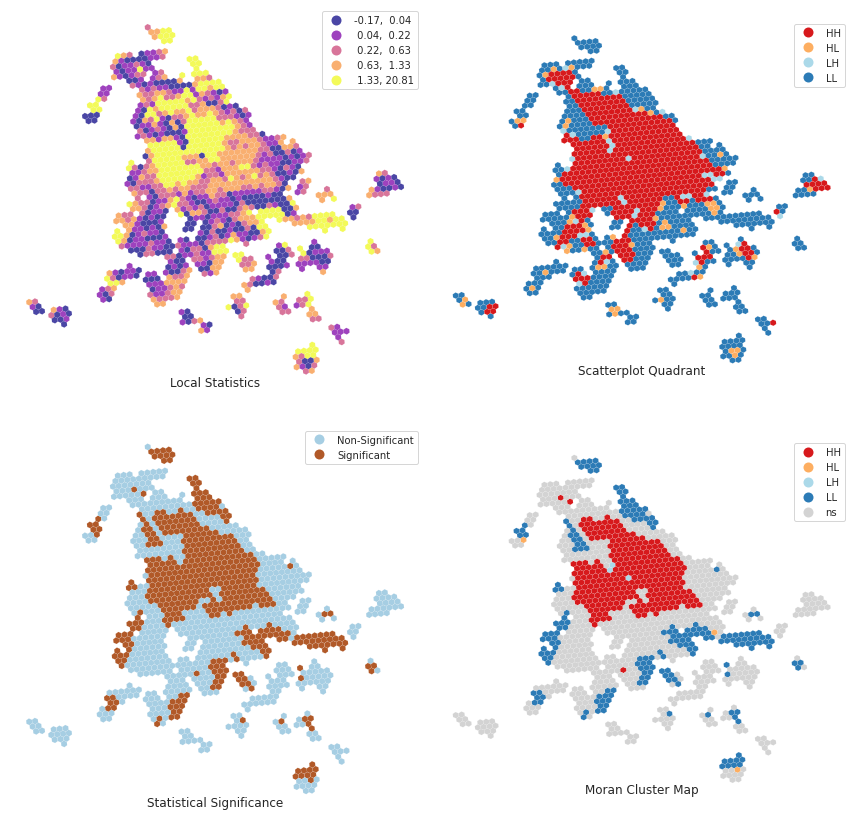

In [201]:
# Set up figure and axes
f, axs = plt.subplots(nrows=2, ncols=2, figsize=(12, 12))
# Make the axes accessible with single indexing
axs = axs.flatten()

                    # Subplot 1 #
            # Choropleth of local statistics
# Grab first axis in the figure
ax = axs[0]
# Assign new column with local statistics on-the-fly
df.assign(
    Is=lisa.Is
# Plot choropleth of local statistics
).plot(
    column='Is', 
    cmap='plasma', 
    scheme='quantiles',
    k=5, 
    edgecolor='white', 
    linewidth=0.1, 
    alpha=0.75,
    legend=True,
    ax=ax
)

                    # Subplot 2 #
                # Quadrant categories
# Grab second axis of local statistics
ax = axs[1]
# Plot Quandrant colors (note to ensure all polygons are assigned a
# quadrant, we "trick" the function by setting significance level to
# 1 so all observations are treated as "significant" and thus assigned
# a quadrant color
esdaplot.lisa_cluster(lisa, df, p=1, ax=ax);

                    # Subplot 3 #
                # Significance map
# Grab third axis of local statistics
ax = axs[2]
# 
# Find out significant observations
labels = pd.Series(
    1 * (lisa.p_sim < 0.05), # Assign 1 if significant, 0 otherwise
    index=df.index           # Use the index in the original data
# Recode 1 to "Significant and 0 to "Non-significant"
).map({1: 'Significant', 0: 'Non-Significant'})
# Assign labels to `db` on the fly
df.assign(
    cl=labels
# Plot choropleth of (non-)significant areas
).plot(
    column='cl', 
    categorical=True,
    k=2,
    cmap='Paired',
    linewidth=0.1,
    edgecolor='white',
    legend=True,
    ax=ax
)

                       
                    # Subplot 4 #
                    # Cluster map
# Grab second axis of local statistics
ax = axs[3]
# Plot Quandrant colors In this case, we use a 5% significance
# level to select polygons as part of statistically significant
# clusters
esdaplot.lisa_cluster(lisa, df, p=0.05, ax=ax);

                    # Figure styling #
# Set title to each subplot
for i, ax in enumerate(axs.flatten()):
    ax.set_axis_off()
    ax.set_title(
        [
            'Local Statistics', 
            'Scatterplot Quadrant', 
            'Statistical Significance', 
            'Moran Cluster Map'
        ][i], y=0
    )
# Tight layout to minimise in-betwee white space
f.tight_layout()

# Display the figure
plt.show()



## Upload

In [94]:
hex_ind['city'] = 'Guadalajara'

In [95]:
aup.gdf_to_db_slow(hex_ind,'mind_the_gap_hexres8', 'mind_the_gap', if_exists='replace')